# Import Libraries

In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Input, BatchNormalization, Activation, merge
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Style Image

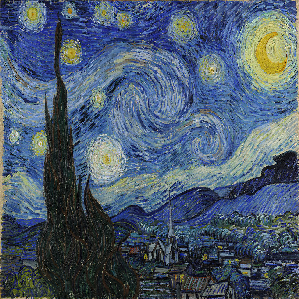

In [2]:
im = Image.open('starry_night.jpg')
im2 = im.resize([299,299])
style = np.array(im2).reshape((1,299,299,3))
im2

# White Noise Image

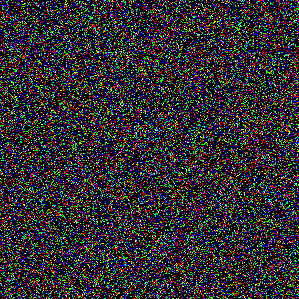

In [3]:
wn = np.random.randn(1,299,299,3)
Image.fromarray(np.uint8(wn.reshape(299,299,3)))

# Xception Model

In [4]:
input_shape=(None, None, 3)
input_tensor=Input(shape=input_shape)
img_input = Input(tensor=input_tensor, shape=input_shape)
x = Conv2D(32, 3, 3, subsample=(2, 2), bias=False, name='block1_conv1')(img_input)
x = BatchNormalization(name='block1_conv1_bn')(x)
x = Activation('relu', name='block1_conv1_act')(x)
x = Conv2D(64, 3, 3, bias=False, name='block1_conv2')(x)
x = BatchNormalization(name='block1_conv2_bn')(x)
x = Activation('relu', name='block1_conv2_act')(x)

residual = Conv2D(128, 1, 1, subsample=(2, 2),
                  border_mode='same', bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(128, 3, 3, border_mode='same', bias=False, name='block2_sepconv1')(x)
x = BatchNormalization(name='block2_sepconv1_bn')(x)
x = Activation('relu', name='block2_sepconv2_act')(x)
x = SeparableConv2D(128, 3, 3, border_mode='same', bias=False, name='block2_sepconv2')(x)
x1 = BatchNormalization(name='block2_sepconv2_bn')(x)
x = x1

x = AveragePooling2D((3, 3), strides=(2, 2), border_mode='same', name='block2_pool')(x)
x = merge([x, residual], mode='sum')

residual = Conv2D(256, 1, 1, subsample=(2, 2),
                  border_mode='same', bias=False)(x)
residual = BatchNormalization()(residual)

x = Activation('relu', name='block3_sepconv1_act')(x)
x = SeparableConv2D(256, 3, 3, border_mode='same', bias=False, name='block3_sepconv1')(x)
x = BatchNormalization(name='block3_sepconv1_bn')(x)
x = Activation('relu', name='block3_sepconv2_act')(x)
x = SeparableConv2D(256, 3, 3, border_mode='same', bias=False, name='block3_sepconv2')(x)
x = BatchNormalization(name='block3_sepconv2_bn')(x)

x = AveragePooling2D((3, 3), strides=(2, 2), border_mode='same', name='block3_pool')(x)
x = merge([x, residual], mode='sum')

residual = Conv2D(728, 1, 1, subsample=(2, 2),
                  border_mode='same', bias=False)(x)
residual = BatchNormalization()(residual)

x = Activation('relu', name='block4_sepconv1_act')(x)
x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name='block4_sepconv1')(x)
x = BatchNormalization(name='block4_sepconv1_bn')(x)
x = Activation('relu', name='block4_sepconv2_act')(x)
x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name='block4_sepconv2')(x)
x = BatchNormalization(name='block4_sepconv2_bn')(x)

x = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same', name='block4_pool')(x)
x2 = merge([x, residual], mode='sum')
x = x2

for i in range(8):
    residual = x
    prefix = 'block' + str(i + 5)

    x = Activation('relu', name=prefix + '_sepconv1_act')(x)
    x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name=prefix + '_sepconv1')(x)
    x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
    x = Activation('relu', name=prefix + '_sepconv2_act')(x)
    x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name=prefix + '_sepconv2')(x)
    x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
    x = Activation('relu', name=prefix + '_sepconv3_act')(x)
    x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name=prefix + '_sepconv3')(x)
    x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

    x = merge([x, residual], mode='sum')

residual = Conv2D(1024, 1, 1, subsample=(2, 2),
                  border_mode='same', bias=False)(x)
residual = BatchNormalization()(residual)

x = Activation('relu', name='block13_sepconv1_act')(x)
x = SeparableConv2D(728, 3, 3, border_mode='same', bias=False, name='block13_sepconv1')(x)
x = BatchNormalization(name='block13_sepconv1_bn')(x)
x = Activation('relu', name='block13_sepconv2_act')(x)
x = SeparableConv2D(1024, 3, 3, border_mode='same', bias=False, name='block13_sepconv2')(x)
x = BatchNormalization(name='block13_sepconv2_bn')(x)

x = AveragePooling2D((3, 3), strides=(2, 2), border_mode='same', name='block13_pool')(x)
x3 = merge([x, residual], mode='sum')
x = x3

x = SeparableConv2D(1536, 3, 3, border_mode='same', bias=False, name='block14_sepconv1')(x)
x = BatchNormalization(name='block14_sepconv1_bn')(x)
x = Activation('relu', name='block14_sepconv1_act')(x)

x = SeparableConv2D(2048, 3, 3, border_mode='same', bias=False, name='block14_sepconv2')(x)
x = BatchNormalization(name='block14_sepconv2_bn')(x)
x = Activation('relu', name='block14_sepconv2_act')(x)

model = Model(img_input, [x1,x2,x3,x], name='xception')

#load weights
model.load_weights('xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Style feature maps

In [5]:
target = model.predict(style)

# Loss and gradient computations

In [6]:
train_iter=0
losses = []

In [7]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x[0],(2,0,1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [8]:
ph_in = K.placeholder(shape=(1,299,299,3))
ph = K.variable(ph_in)
ph_out = model(ph)
ph_out1,ph_out2,ph_out3,ph_out4 = K.relu(ph_out[0]),K.relu(ph_out[1]),K.relu(ph_out[2]),K.relu(ph_out[3])

#compute gram matricies
g1,g1_t = gram_matrix(ph_out1),gram_matrix(target[0])
#g2,g2_t = gram_matrix(ph_out2),gram_matrix(target[1])
#g3,g3_t = gram_matrix(ph_out3),gram_matrix(target[2])
#g4,g4_t = gram_matrix(ph_out4),gram_matrix(target[3])

#compute loss
loss = 0.5*(K.sum(K.square(g1-g1_t)))

# loss = 0.5*(K.sum(K.square(g1-g1_t))+
#             K.sum(K.square(g2-g2_t))+
#             K.sum(K.square(g3-g3_t))+
#             K.sum(K.square(g4-g4_t)))

#compute gradients
grad_op = K.gradients(loss,ph)

init = tf.initialize_all_variables()

# Reconstruct iterations

In [22]:
step_size = 10**(-9)
#step_size = 1
num_steps = 50

sess = tf.Session()
K.set_session(sess)

for i in tqdm(range(num_steps)):
    sess.run([init],feed_dict={ph_in:wn})
    l,derivates = sess.run([loss,grad_op],feed_dict={K.learning_phase(): 1})
    wn = np.clip(wn-step_size*derivates[0],0,255)
    #wn = wn-step_size*derivates
    losses.append(l)
    
    #save the image every 20 steps
    if i % 20 == 0:
        train_iter+=1
        Image.fromarray(np.uint8(wn.reshape(299,299,3))).save('DreamStyle2/dream_'+str(train_iter)+'.jpg')

100%|██████████| 50/50 [00:29<00:00,  1.89it/s]


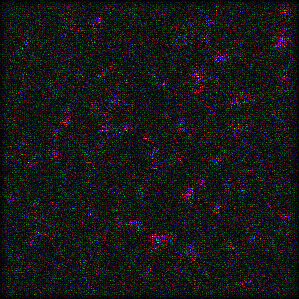

In [23]:
Image.fromarray(np.uint8(wn.reshape(299,299,3)))

In [19]:
np.mean(np.abs(derivates[0]))

1.2145891e+09

In [20]:
#np.clip(wn,0,255)

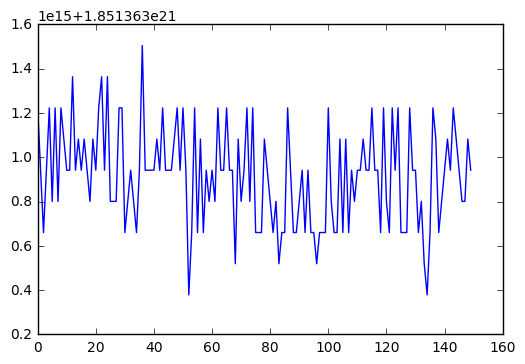

In [21]:
plt.plot(losses)